## 1. Obtención de los datos

En esta sección, se carga los datos desde la base de datos y se va a convertir la serie temporal de ventas en un ejercicio Supervisado.

### 1.1 Cargar los datos desde la base de datos

Para la conexión con la base de datos se usa las librerías de `pandas` para mejorar los datos y `sqlalchemy` para la conexión con al base de datos.

In [ ]:
import pandas as pd
import sqlalchemy as sa


class DatabaseConnection:

    def __init__(
        self,
        username: str,
        password: str,
        database: str = "##",
        host: str = "##",
        port: int = ##,
        dialect: str = "mysql",
        driver: str = "pymysql",
    ) -> None:
        """Creates a connection to a database

        Args:
            username (str): username
            password (str): password
            dialect (str, optional): dialect. Defaults to "mysql".
            driver (str, optional): driver. Defaults to "pymysql".
            host (str, optional): host. Defaults to "##".
            port (int, optional): port. Defaults to ##.
            database (str, optional): database. Defaults to "data".
        """
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserts a dataframe into a table
        
        Args:
            df (pd.DataFrame): dataframe to insert
            table_name (str): table name
        """
        df.to_sql(table_name, self.engine, if_exists="replace", index=False)

    def query_to_df(self, query: str) -> pd.DataFrame:
        """Retrieves a dataframe from a query.

        Args:
            query (str): query to perform.

        Returns:
            pd.DataFrame: daframe with the results of the query.
        """
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df

    def check_connection(self) -> bool:
        """Checks if the connection is working

        Returns:
            bool: True if the connection is working, False otherwise
        """
        try:
            self.engine.connect()
        except Exception as e:
            print(e)
            return False

In [ ]:
DB_USERNAME = "###"
DB_PASSWORD = "####"
LOCATION = (###, ###)

Conexión con la base de datos

In [45]:
database = DatabaseConnection(DB_USERNAME, DB_PASSWORD)
database.check_connection()

Se realiza una consulta SQL para obtener los datos y se comprueba que funciona correctamente con un .info

In [46]:
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

    FROM jpra_ventas_diarias_estudio
"""

df = database.query_to_df(query)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   familia                 10322 non-null  object 
 1   articulo                10322 non-null  object 
 2   fecha_venta             10322 non-null  object 
 3   festivo                 809 non-null    object 
 4   precio                  10322 non-null  float64
 5   cantidad                10322 non-null  float64
 6   importe                 10322 non-null  float64
 7   orden_articulo_familia  10322 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 645.3+ KB


Se muestra los primeros valores.

In [47]:
df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3880,2021-05-01,None,2.591,285.000,738.434998,3
1,BOLLERIA,3960,2021-05-01,None,2.318,402.000,931.835995,1
2,BOLLERIA,5803,2021-05-01,None,2.727,237.000,646.298981,5
3,BOLLERIA,6286,2021-05-01,None,3.136,165.000,517.440006,4
4,BOLLERIA,6425,2021-05-01,None,31.364,31.725,995.022083,2


Convertimos las fechas a formato datetime y los artículos a tipo int.

In [48]:
df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
df["articulo"] = df["articulo"].astype(int)

Se organiza los datos por fecha y se reinicia el índice.

In [49]:
df.sort_values(["fecha_venta"], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3880,2021-05-01,None,2.591,285.0,738.434998,3
1,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5
2,PANADERIA,1084,2021-05-01,None,0.865,423.0,365.895005,4
3,PANADERIA,1043,2021-05-01,None,2.596,327.0,848.892002,2
4,PASTELERIA,5403,2021-05-01,None,34.091,3.0,102.273003,2


Nota: Todo lo relacionado al EDA está en el notebook [EDA](./DataScience-Project/Datathon_Bakery/2.%20EDA.ipynb)

### 1.2 Convertir la serie en formato supervisado

Para predecir las ventas, se necesita transformar los datos a un problema supervisado, para ello:    
- Se deberá obtener la `cantidad` contabilizada de los días anteriores y añadirlos al día presente.
- Se deberá obtener `cantidad` contabilizada de las semanas anteriores y añadirlos al día presente.

Se diseña una función que permite transformar la serie a formato supervisado.
La función recibe como parámetros el dataframe, número de días y semanas a considerar. 

In [50]:
def multi_product_series_to_supervised(
    df: pd.DataFrame,
    target_column: str = "cantidad",
    id_column: str = "articulo",
    daily_lag: int = 1,
    weekly_lag: int = 1,
) -> pd.DataFrame:
    """
    Converts multiple time series (grouped by product) into a supervised learning dataset.
    
    Args:
        df: Input DataFrame with columns: fecha_venta, articulo, cantidad, etc.
        target_column: Name of the target variable column (default: "cantidad").
        id_column: Name of the column identifying products (default: "articulo").
        daily_lag: Number of daily lags to include (default: 1).
        weekly_lag: Number of weekly lags to include (default: 1).
    
    Returns:
        DataFrame with lagged features for each product.
    """
    # Verificar que la columna de fecha existe
    if 'fecha_venta' not in df.columns:
        raise ValueError("El DataFrame debe contener una columna 'fecha_venta'.")

    resultados = []
    
    # Ordenar por artículo y fecha
    df = df.sort_values([id_column, 'fecha_venta'])
    
    for articulo in df[id_column].unique():
        # Filtrar datos para el artículo actual
        df_articulo = df[df[id_column] == articulo].copy()
        
        # Crear características de lag para este artículo
        target_feature = df_articulo[target_column]
        
        # Función interna para crear lags
        def create_shifted_feature(lag: int, frequency: int, freq_label: str):
            shifted_feature = target_feature.shift(lag * frequency)
            feature_name = f"{target_column}_lag_{lag}_{freq_label}"
            df_articulo[feature_name] = shifted_feature
        
        # Añadir lags semanales (t-7, t-14, ...)
        for lag in range(1, weekly_lag + 1):
            create_shifted_feature(lag, 7, "weeks")
        
        # Añadir lags diarios (t-1, t-2, ...)
        for lag in range(1, daily_lag + 1):
            create_shifted_feature(lag, 1, "days")
        
        resultados.append(df_articulo)
    
    # Combinar todos los DataFrames y resetear índice
    return pd.concat(resultados).reset_index(drop=True)

In [51]:
df_supervised = multi_product_series_to_supervised(
    df=df,  # <- Aquí usas tu DataFrame real
    target_column="cantidad",
    id_column="articulo",
    daily_lag=6,  # Lags diarios: t-1, t-2, ..., t-6
    weekly_lag=4   # Lags semanales: t-7, t-14, t-21, t-28
)
df_supervised.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad_lag_1_weeks,cantidad_lag_2_weeks,cantidad_lag_3_weeks,cantidad_lag_4_weeks,cantidad_lag_1_days,cantidad_lag_2_days,cantidad_lag_3_days,cantidad_lag_4_days,cantidad_lag_5_days,cantidad_lag_6_days
0,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN
2,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,NaN,NaN,NaN,NaN,81.0,72.0,NaN,NaN,NaN,NaN
3,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192001,5,NaN,NaN,NaN,NaN,90.0,81.0,72.0,NaN,NaN,NaN
4,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192003,5,NaN,NaN,NaN,NaN,84.0,90.0,81.0,72.0,NaN,NaN


In [52]:
df_supervised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   festivo                 809 non-null    object        
 4   precio                  10322 non-null  float64       
 5   cantidad                10322 non-null  float64       
 6   importe                 10322 non-null  float64       
 7   orden_articulo_familia  10322 non-null  int64         
 8   cantidad_lag_1_weeks    10217 non-null  float64       
 9   cantidad_lag_2_weeks    10112 non-null  float64       
 10  cantidad_lag_3_weeks    10007 non-null  float64       
 11  cantidad_lag_4_weeks    9902 non-null   float64       
 12  cantidad_lag_1_days     10307 non-null  float6

## 2. Procesamiento de los datos

En este paso se creará un Flujo de Transformación de Datos (Data Pipeline).

### 2.1 Extraer info de la fecha de venta

Con este campo se va a crear las siguientes columnas:

- dayofweek: Día de la semana.
- day: Día del mes.
- month: El mes.
- year: El año.
- weekend: Si es fin de semana.

Se va a crear la siguiente función para extraer los nuevos campos y adicionarlos al df.

In [53]:
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df["day"] = df[date_column].dt.day
    df["month"] = df[date_column].dt.month
    df["year"] = df[date_column].dt.year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1
    df["isWeekend"] = df["dayofweek"] >= 6
    return df

df_supervised_tmp = add_date_columns(df_supervised.copy())
df_supervised_tmp.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad_lag_1_weeks,cantidad_lag_2_weeks,...,cantidad_lag_2_days,cantidad_lag_3_days,cantidad_lag_4_days,cantidad_lag_5_days,cantidad_lag_6_days,day,month,year,dayofweek,isWeekend
0,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,5,2021,6,True
1,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2,5,2021,7,True
2,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,NaN,NaN,...,72.0,NaN,NaN,NaN,NaN,3,5,2021,1,False
3,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192001,5,NaN,NaN,...,81.0,72.0,NaN,NaN,NaN,4,5,2021,2,False
4,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192003,5,NaN,NaN,...,90.0,81.0,72.0,NaN,NaN,5,5,2021,3,False


### 2.2 Agregar columnas adicionales

Se agrega las siguientes columnas:

- `isHoliday`: Indica con un True y False si es un día festivo o no.
- `isBridgeDay`: Solo aplica para días que son puentes cuando el festivo es un jueves, el valor se marcará True un viernes y si el festivo es martes, el lunes se marcará como True.
- `preHoliday`: Indica True si el día es un día anterior a un festivo.
- `postHoliday`: Indica True si hay un festivo el día anterior.

Además la función elimina la columna de `festivo` porque ya se está usando la columna `isHoliday`


In [54]:
from datetime import timedelta
import pandas as pd

def add_holiday_features(
    df: pd.DataFrame,
    date_column: str = "fecha_venta",
    raw_holiday_column: str = "festivo",
    holiday_column: str = "isHoliday"
) -> pd.DataFrame:
    """
    Añade columna booleana de festivo (`isHoliday`) y contexto:
    - isBridgeDay: Viernes si el festivo es jueves, o lunes si es martes.
    - preHoliday: Día anterior a un festivo.
    - postHoliday: Día posterior a un festivo.
    """
    df = df.copy()

    # Convertir fechas si es necesario
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Crear columna isHoliday desde la columna original de festivos
    if raw_holiday_column in df.columns:
        df[holiday_column] = ~df[raw_holiday_column].isna()
        df.drop(columns=[raw_holiday_column], inplace=True)
    else:
        print(f"Advertencia: Columna '{raw_holiday_column}' no encontrada. No se marcarán festivos.")
        df[holiday_column] = False

    # Inicializar columnas de contexto
    df["isBridgeDay"] = False
    df["preHoliday"] = False
    df["postHoliday"] = False

    # Identificar fechas festivas
    holiday_dates = df.loc[df[holiday_column], date_column].dropna().unique()

    for holiday in holiday_dates:
        try:
            holiday = pd.to_datetime(holiday)

            pre_day = holiday - timedelta(days=1)
            post_day = holiday + timedelta(days=1)

            df.loc[df[date_column] == pre_day, "preHoliday"] = True
            df.loc[df[date_column] == post_day, "postHoliday"] = True

            if holiday.weekday() == 3:  # Jueves -> puente viernes
                df.loc[df[date_column] == (holiday + timedelta(days=1)), "isBridgeDay"] = True
            elif holiday.weekday() == 1:  # Martes -> puente lunes
                df.loc[df[date_column] == (holiday - timedelta(days=1)), "isBridgeDay"] = True

        except Exception as e:
            print(f"Error procesando fecha {holiday}: {str(e)}")

    return df


df_supervised_tmp = add_holiday_features(df_supervised.copy())
df_supervised_tmp.head()

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,cantidad_lag_1_weeks,cantidad_lag_2_weeks,cantidad_lag_3_weeks,...,cantidad_lag_1_days,cantidad_lag_2_days,cantidad_lag_3_days,cantidad_lag_4_days,cantidad_lag_5_days,cantidad_lag_6_days,isHoliday,isBridgeDay,preHoliday,postHoliday
0,PANADERIA,417,2021-05-01,4.038,72.0,290.736004,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
1,PANADERIA,417,2021-05-02,4.038,81.0,327.077995,5,NaN,NaN,NaN,...,72.0,NaN,NaN,NaN,NaN,NaN,True,False,True,False
2,PANADERIA,417,2021-05-03,4.038,90.0,363.419998,5,NaN,NaN,NaN,...,81.0,72.0,NaN,NaN,NaN,NaN,True,False,False,True
3,PANADERIA,417,2021-05-04,4.038,84.0,339.192001,5,NaN,NaN,NaN,...,90.0,81.0,72.0,NaN,NaN,NaN,False,False,False,True
4,PANADERIA,417,2021-05-05,4.038,84.0,339.192003,5,NaN,NaN,NaN,...,84.0,90.0,81.0,72.0,NaN,NaN,False,False,False,False


### 2.3 Se agrega Información meteorológica


Se utiliza la API de meteostat para obtener los datos meteorológicos.
Se añadirá la columna `isRaining` para indicar si ese día hubo lluvia o no. Los valores serán verdader o falso.

In [23]:
from datetime import datetime
from meteostat import Point, Daily
import numpy as np


def get_weather_df(start: datetime, end: datetime, location: tuple[int, int]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().fillna(0).reset_index()

def merge_dfs_by_column(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
    merged_df.index.name = None
    return merged_df

def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

def add_weather_columns(
    df: pd.DataFrame,
    location: tuple[int, int],
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_df(start, end, location)
    weather_df = add_rain_column(weather_df)
    weather_df = merge_dfs_by_column(df, weather_df, date_column_name, "time")
    return weather_df


df_supervised_tmp = df_supervised.copy()
add_weather_columns(df_supervised, LOCATION).head()


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad_lag_1_weeks,cantidad_lag_2_weeks,...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
0,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,NaN,NaN,...,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
1,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,NaN,NaN,...,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,NaN,NaN,...,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
3,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192001,5,NaN,NaN,...,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
4,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192003,5,NaN,NaN,...,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False


## 3. Creación de Pipeline

### 3.1 Preprocesamiento de los datos de entrada

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin


class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[int, int], daily_lag: int, weekly_lag: int):
        self.location = location
        self.daily_lag = daily_lag
        self.weekly_lag = weekly_lag

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()  # avoid modifying incoming data
        X = add_date_columns(X)
        X = add_holiday_features(X)
        X = add_weather_columns(X, location=self.location)
        return X

In [60]:
preprocessor = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df = preprocessor.transform(df_supervised)
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10322 entries, 0 to 10321
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   precio                  10322 non-null  float64       
 4   cantidad                10322 non-null  float64       
 5   importe                 10322 non-null  float64       
 6   orden_articulo_familia  10322 non-null  int64         
 7   cantidad_lag_1_weeks    10217 non-null  float64       
 8   cantidad_lag_2_weeks    10112 non-null  float64       
 9   cantidad_lag_3_weeks    10007 non-null  float64       
 10  cantidad_lag_4_weeks    9902 non-null   float64       
 11  cantidad_lag_1_days     10307 non-null  float64       
 12  cantidad_lag_2_days     10292 non-null  float64    

### 3.2 Normalización de los datos de entrada

Antes de hacer indicar los valores, se eliminaran las siguientes columnas porque no aportan ningún valor en nuestro dataframe, ya que éstas columnas tienen valores 0 `snow`, `wdir` y `tsun`.

Y la columna `prcp` porque se utilizó para crear la columna `isRaining`

In [61]:
preprocessed_df = preprocessed_df.drop(columns=["snow", "wdir", "tsun", "prcp"])
preprocessed_df.columns

Index(['familia', 'articulo', 'fecha_venta', 'precio', 'cantidad', 'importe',
       'orden_articulo_familia', 'cantidad_lag_1_weeks',
       'cantidad_lag_2_weeks', 'cantidad_lag_3_weeks', 'cantidad_lag_4_weeks',
       'cantidad_lag_1_days', 'cantidad_lag_2_days', 'cantidad_lag_3_days',
       'cantidad_lag_4_days', 'cantidad_lag_5_days', 'cantidad_lag_6_days',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday',
       'isBridgeDay', 'preHoliday', 'postHoliday', 'time', 'tavg', 'tmin',
       'tmax', 'wspd', 'wpgt', 'pres', 'isRaining'],
      dtype='object')

Para la normalización de los datos se utiliza `OneHotEncoder` para las variables categoricas y `MinMaxScaler`. para las variables numéricas.

In [62]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector


categorical_features = make_column_selector(dtype_include=[object, np.int32])
numerical_features = make_column_selector(dtype_include=[np.float64])

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

encoders_transformer = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_encoder, categorical_features),
        ("MinMaxScaler", minmax_scaler, numerical_features),
    ],
)

### 3.3 Eliminar los valores nulos

En este paso se rellena los valores nulos calculando la media de cada columna.

In [63]:
from sklearn.impute import SimpleImputer


nans_remover = SimpleImputer(strategy="mean")
remove_nans_transformer = ColumnTransformer(
    transformers=[
        ("RemoveNans", nans_remover, numerical_features),
    ],
)


### 3.4 Incluir el modelo de Machine Learning

Como nos encontramos en un problema de regresión porque se quiere predecir las cantidades vendidas, se va a utilizar un modelo de regresión. En este caso, vamos a utilizar el modelo `LinearRegression` de Scikit-Learn.

In [64]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()

### 3.5 Creamos el pipeline para las variables de entrada

Se agrega los pasos anteriores al pipeline de transformación de datos de forma secuencial. El pipeline se encargará de aplicar las transformaciones a los datos de entrada y de entrenar el modelo.

In [65]:
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

,steps,"[('preprocessor', ...), ('nan_remover', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,location,"(36.721477644071705, ...)"
,daily_lag,6
,weekly_lag,4
,transformers,"[('RemoveNans', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None


### 3.6 Normalizar la variable objetivo

En ultimo paso, se usa el mismo `OneHotEncoder` utilizado para los datos de entrada para codificar la variable objetivo (target), pero sin ajustarlo nuevamente. Esto asegura que la variable objetivo esté en el mismo formato que los datos de entrada, facilitando así la predicción y evaluación del modelo.

In [66]:
from sklearn.compose import TransformedTargetRegressor


target_feature_scaler = MinMaxScaler(feature_range=(0,1))
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=target_feature_scaler,
)
final_pipeline

,regressor,Pipeline(step...egression())])
,transformer,MinMaxScaler()
,func,None
,inverse_func,None
,check_inverse,True
,location,"(36.721477644071705, ...)"
,daily_lag,6
,weekly_lag,4
,transformers,"[('RemoveNans', ...)]"
,remainder,'drop'
,sparse_threshold,0.3


## 4. Entrenar el modelo

Se utiliza el pipeline creado anteriormente para entrenar el modelo. Marcamos el horizonte de tiempo del conjunto de test a 30 días. Esto significa que el modelo se evaluará con los datos de los últimos 30 días y se entrenará con los datos previos a dicho horizonte.

Se entrena el modelo por artículos porque no todos los artículos dentro de las familias se comportan de la misma manera.

In [67]:
def split_by_article(df: pd.DataFrame, article_col: str = "articulo") -> dict[int, pd.DataFrame]:
    """
    Divide el DataFrame en diccionario de DataFrames, uno por artículo.
    
    Args:
        df: DataFrame con todos los datos.
        article_col: Nombre de la columna que contiene los IDs de artículos.
    
    Returns:
        Un diccionario donde las claves son los IDs de artículos y los valores son DataFrames filtrados.
    """
    articles = df[article_col].unique()
    return {article: df[df[article_col] == article].copy() for article in articles}

In [68]:
dict_articulos = split_by_article(df_final, article_col="articulo")

In [69]:
print("Artículos disponibles:", dict_articulos.keys())

Artículos disponibles: dict_keys([np.int64(417), np.int64(900), np.int64(968), np.int64(1043), np.int64(1084), np.int64(3880), np.int64(3960), np.int64(5403), np.int64(5404), np.int64(5803), np.int64(6286), np.int64(6425), np.int64(6451), np.int64(6523), np.int64(6549)])


Se asignará los df creados en valores para poder entrenarlos por artículo

In [ ]:
df_articulo_417 = dict_articulos[417]
df_articulo_900 = dict_articulos[900]
df_articulo_968 = dict_articulos[968]
df_articulo_1043 = dict_articulos[1043]
df_articulo_1084 = dict_articulos[1084]
df_articulo_3880 = dict_articulos[3880]
df_articulo_3960 = dict_articulos[3960]
df_articulo_5403 = dict_articulos[5403]
df_articulo_5404 = dict_articulos[5404]
df_articulo_5803 = dict_articulos[5803]
df_articulo_6286 = dict_articulos[6286]
df_articulo_6425 = dict_articulos[6425]
df_articulo_6451 = dict_articulos[6451]
df_articulo_6523 = dict_articulos[6523]
df_articulo_6549 = dict_articulos[6549]


In [71]:
df_articulo_1043.head()

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,cantidad_lag_1_weeks,cantidad_lag_2_weeks,cantidad_lag_3_weeks,...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
2190,PANADERIA,1043,2021-05-01,2.596,327.0,848.892002,2,NaN,NaN,NaN,...,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
2191,PANADERIA,1043,2021-05-02,2.596,303.0,786.587997,2,NaN,NaN,NaN,...,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2192,PANADERIA,1043,2021-05-03,2.596,216.0,560.735996,2,NaN,NaN,NaN,...,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
2193,PANADERIA,1043,2021-05-04,2.596,177.0,459.491999,2,NaN,NaN,NaN,...,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
2194,PANADERIA,1043,2021-05-05,2.596,180.0,467.279993,2,NaN,NaN,NaN,...,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False


Se guarda la familia a la que pertennece el producto para guaradrlo como tag en MLFlow

### 4.1 Pequeña limpieza de los datos

Se elimina columnas que no se van a utilizar en el modelo

In [76]:
drop_cols = ['importe', 'articulo', 'familia', 'orden_articulo_familia',"snow", "wdir", "tsun", "prcp"]

df_articulo_417 = df_articulo_417.drop(columns=drop_cols)
df_articulo_900 = df_articulo_900.drop(columns=drop_cols)
df_articulo_968 = df_articulo_968.drop(columns=drop_cols)
df_articulo_1043 =df_articulo_1043.drop(columns=drop_cols)
df_articulo_1084 =df_articulo_1084.drop(columns=drop_cols)
df_articulo_3880 =df_articulo_3880.drop(columns=drop_cols)
df_articulo_3960 =df_articulo_3960.drop(columns=drop_cols)
df_articulo_5403 =df_articulo_5403.drop(columns=drop_cols)
df_articulo_5404 =df_articulo_5404.drop(columns=drop_cols)
df_articulo_5803 =df_articulo_5803.drop(columns=drop_cols)
df_articulo_6286 =df_articulo_6286.drop(columns=drop_cols)
df_articulo_6425 =df_articulo_6425.drop(columns=drop_cols)
df_articulo_6451 =df_articulo_6451.drop(columns=drop_cols)
df_articulo_6523 =df_articulo_6523.drop(columns=drop_cols)
df_articulo_6549 =df_articulo_6549.drop(columns=drop_cols)

dfs_articulos = {
    417: df_articulo_417,
    900: df_articulo_900,
    968: df_articulo_968,
    1043: df_articulo_1043,
    1084: df_articulo_1084,
    3880: df_articulo_3880,
    3960: df_articulo_3960,
    5403: df_articulo_5403,
    5404: df_articulo_5404,
    5803: df_articulo_5803,
    6286: df_articulo_6286,
    6425: df_articulo_6425,
    6451: df_articulo_6451,
    6523: df_articulo_6523,
    6549: df_articulo_6549
}

In [77]:
dfs_articulos[417].columns

Index(['fecha_venta', 'precio', 'cantidad', 'cantidad_lag_1_weeks',
       'cantidad_lag_2_weeks', 'cantidad_lag_3_weeks', 'cantidad_lag_4_weeks',
       'cantidad_lag_1_days', 'cantidad_lag_2_days', 'cantidad_lag_3_days',
       'cantidad_lag_4_days', 'cantidad_lag_5_days', 'cantidad_lag_6_days',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday',
       'isBridgeDay', 'preHoliday', 'postHoliday', 'time', 'tavg', 'tmin',
       'tmax', 'wspd', 'wpgt', 'pres', 'isRaining'],
      dtype='object')

### 4.2. Se divide en conjuntos de entrenamiento y test.

In [89]:
from datetime import datetime


# DICCIONARIO CON LOS DATAFRAMES
dfs_articulos 

# --- CÓDIGO MODIFICADO ---
# La función de preparación de datos ahora se encarga solo de la partición de los datos
def preparar_datos_para_modelado(
    dfs_articulos: dict,
    target_col: str = "cantidad",
    horizont: datetime = datetime(2023, 3, 31)
) -> dict:
    resultados = {}
    for id_articulo, df in dfs_articulos.items():
        try:
            mask_train = df["fecha_venta"] < horizont
            mask_test = df["fecha_venta"] >= horizont

            df_train = df.loc[mask_train].copy()
            df_test = df.loc[mask_test].copy()
            
            # Aquí es donde realmente usas 'fecha_venta' para el split, después ya no se necesita.
            X_train = df_train.drop(columns=[target_col])
            y_train = df_train[target_col]
            X_test = df_test.drop(columns=[target_col])
            y_test = df_test[target_col]
            

            resultados[id_articulo] = {
                "X_train": X_train,
                "y_train": y_train,
                "X_test": X_test,
                "y_test": y_test,
                "df_test": df_test
            }
        except Exception as e:
            print(f"❌ Error procesando artículo {id_articulo}: {str(e)}")

    return resultados

# Ejecuta la preparación de datos con la función modificada
datos_preparados = preparar_datos_para_modelado(dfs_articulos)




Se define la familia para poder guardarlo como un tag en MLFlow

In [90]:
familias_por_articulo = {
    3960: "BOLLERIA",
    5803: "BOLLERIA",
    3880: "BOLLERIA",
    6286: "BOLLERIA",
    6425: "BOLLERIA",
    1084: "PANADERIA",
    417: "PANADERIA", 
    900: "PANADERIA",
    968: "PANADERIA",
    1043: "PANADERIA",
    6451: "PASTELERIA",
    6549: "PASTELERIA",
    6523: "PASTELERIA",
    5403: "PASTELERIA",
    5404: "PASTELERIA"
}

In [91]:
type(familias_por_articulo)

dict

### 4.3 Iniciar el servidor de MLFlow

In [97]:
import mlflow

# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Datathon V"
MLFLOW_TRACKING_URI = "http://localhost:5000"


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/523618784756416889', creation_time=1754591108677, experiment_id='523618784756416889', last_update_time=1754591108677, lifecycle_stage='active', name='Datathon V', tags={}>

Se verifica si el pipeline está correctamente configurado.

In [82]:
print("✅ Pipeline configurado correctamente:")
print(final_pipeline)

✅ Pipeline configurado correctamente:
TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      PreprocessTransformer(daily_lag=6,
                                                                            location=(36.721477644071705,
                                                                                      -4.363132134392174),
                                                                            weekly_lag=4)),
                                                     ('nan_remover',
                                                      ColumnTransformer(transformers=[('RemoveNans',
                                                                                       SimpleImputer(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x0000015DA08F78D0>)])),
                                            

### 4.4 Entrenar modelo y evaluar

In [98]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def entrenar_modelo_final(id_articulo, datos_articulo):
    try:
        with mlflow.start_run(run_name=f"Artículo_{id_articulo}"):
            X_train = datos_articulo["X_train"]
            y_train = datos_articulo["y_train"]
            X_test = datos_articulo["X_test"]
            y_test = datos_articulo["y_test"]

            # Ya no es necesario el filtro de columnas, el pipeline lo maneja
            # X_train = X_train.select_dtypes(...)
            # X_test = X_test.select_dtypes(...)
            
            if len(X_train) == 0 or len(X_test) == 0:
                print(f"⚠️ Artículo {id_articulo}: Sin datos suficientes")
                return None
            
            print(f"Tipo de familias_por_articulo: {type(familias_por_articulo)}")
            familia = familias_por_articulo.get(id_articulo, "Desconocida")
            print(f"Familia para artículo {id_articulo}: {familia}")

            familia = familias_por_articulo.get(id_articulo, "Desconocida")
            mlflow.set_tags({
                "articulo": str(id_articulo),
                "familia": familia,
                "modelo": "LinearRegression+PipelineCompleto"
            })
            
            final_pipeline.fit(X_train, y_train)
            
            y_pred = final_pipeline.predict(X_test)
            
            metrics = {
                "mae_test": mean_absolute_error(y_test, y_pred),
                "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred)),
                "r2_test": r2_score(y_test, y_pred)
            }
            
            mlflow.log_metrics(metrics)
            mlflow.sklearn.log_model(final_pipeline, "model")
            
            print(f"✅ {id_articulo} ({familia}) - MAE: {metrics['mae_test']:.2f}")
            return metrics
            
    except Exception as e:
        print(f"❌ Error en artículo {id_articulo}: {str(e)}")
        return None

# --- Bucle para entrenar los modelos ---
resultados_finales = {}
for id_articulo, datos_articulo in datos_preparados.items():
    print(f"\n🔍 Procesando artículo {id_articulo}...")
    resultado = entrenar_modelo_final(id_articulo, datos_articulo)
    if resultado is not None:
        resultados_finales[id_articulo] = resultado

# Mostrar resumen
print("\n🎯 Resultados Finales:")
for art, res in resultados_finales.items():
    print(f"Artículo {art}: MAE={res['mae_test']:.2f} | R²={res['r2_test']:.2f}")



🔍 Procesando artículo 417...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 417: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 417 (PANADERIA) - MAE: 9.94
🏃 View run Artículo_417 at: http://localhost:5000/#/experiments/523618784756416889/runs/fe9ddab155684e92a66e55fa62e1e0c1
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 900...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 900: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 900 (PANADERIA) - MAE: 84.23
🏃 View run Artículo_900 at: http://localhost:5000/#/experiments/523618784756416889/runs/ca29b671615b4ff4ab68f5b849474b54
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 968...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 968: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 968 (PANADERIA) - MAE: 37.21
🏃 View run Artículo_968 at: http://localhost:5000/#/experiments/523618784756416889/runs/773b77b9c9d94b81bf81e275a93a703d
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 1043...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 1043: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 1043 (PANADERIA) - MAE: 45.33
🏃 View run Artículo_1043 at: http://localhost:5000/#/experiments/523618784756416889/runs/f30140c6bf8c4d34bd4d589074f188bd
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 1084...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 1084: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 1084 (PANADERIA) - MAE: 42.91
🏃 View run Artículo_1084 at: http://localhost:5000/#/experiments/523618784756416889/runs/a443dd2133fb48a586c918477272193f
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 3880...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 3880: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 3880 (BOLLERIA) - MAE: 27.40
🏃 View run Artículo_3880 at: http://localhost:5000/#/experiments/523618784756416889/runs/310df66300b64bea8f3a722f779f76c5
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 3960...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 3960: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 3960 (BOLLERIA) - MAE: 36.19
🏃 View run Artículo_3960 at: http://localhost:5000/#/experiments/523618784756416889/runs/7b0679a188414c159ba8837a975ba81e
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 5403...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 5403: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 5403 (PASTELERIA) - MAE: 9.05
🏃 View run Artículo_5403 at: http://localhost:5000/#/experiments/523618784756416889/runs/6571c3de20954bbb91ef498a36029c52
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 5404...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 5404: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 5404 (PASTELERIA) - MAE: 9.64
🏃 View run Artículo_5404 at: http://localhost:5000/#/experiments/523618784756416889/runs/f4d1685ab6e546ef8f9aa1af983f0fda
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 5803...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 5803: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 5803 (BOLLERIA) - MAE: 21.80
🏃 View run Artículo_5803 at: http://localhost:5000/#/experiments/523618784756416889/runs/76aebb6fc018489f91c89c3a7a14238b
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6286...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6286: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6286 (BOLLERIA) - MAE: 20.82
🏃 View run Artículo_6286 at: http://localhost:5000/#/experiments/523618784756416889/runs/71524c0b589b4efd925e47374862cb4e
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6425...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6425: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6425 (BOLLERIA) - MAE: 6.98
🏃 View run Artículo_6425 at: http://localhost:5000/#/experiments/523618784756416889/runs/aa67f3d55bd64d64ada070f37e4790ec
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6451...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6451: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6451 (PASTELERIA) - MAE: 5.33
🏃 View run Artículo_6451 at: http://localhost:5000/#/experiments/523618784756416889/runs/9993c40f29984b589445b6b805370506
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6523...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6523: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6523 (PASTELERIA) - MAE: 6.06
🏃 View run Artículo_6523 at: http://localhost:5000/#/experiments/523618784756416889/runs/bf5adc72c3534c6db27e0d0e89a5e549
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6549...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6549: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/09 21:49:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6549 (PASTELERIA) - MAE: 6.68
🏃 View run Artículo_6549 at: http://localhost:5000/#/experiments/523618784756416889/runs/5587b600d93d4f1a97da6e84d05f37dd
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🎯 Resultados Finales:
Artículo 417: MAE=9.94 | R²=-0.10
Artículo 900: MAE=84.23 | R²=-0.55
Artículo 968: MAE=37.21 | R²=0.27
Artículo 1043: MAE=45.33 | R²=0.28
Artículo 1084: MAE=42.91 | R²=-0.07
Artículo 3880: MAE=27.40 | R²=0.27
Artículo 3960: MAE=36.19 | R²=0.34
Artículo 5403: MAE=9.05 | R²=0.07
Artículo 5404: MAE=9.64 | R²=0.22
Artículo 5803: MAE=21.80 | R²=0.12
Artículo 6286: MAE=20.82 | R²=0.57
Artículo 6425: MAE=6.98 | R²=-0.01
Artículo 6451: MAE=5.33 | R²=0.06
Artículo 6523: MAE=6.06 | R²=-0.24
Artículo 6549: MAE=6.68 | R²=-0.24


### 4.5 Crear gráficos de resultados


🎨 Graficando artículo 417...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


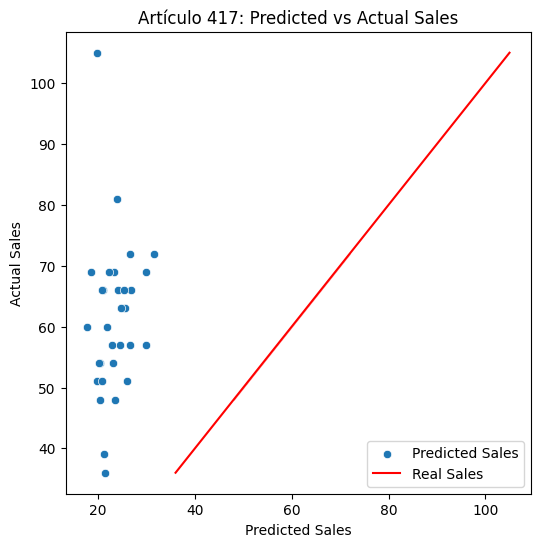

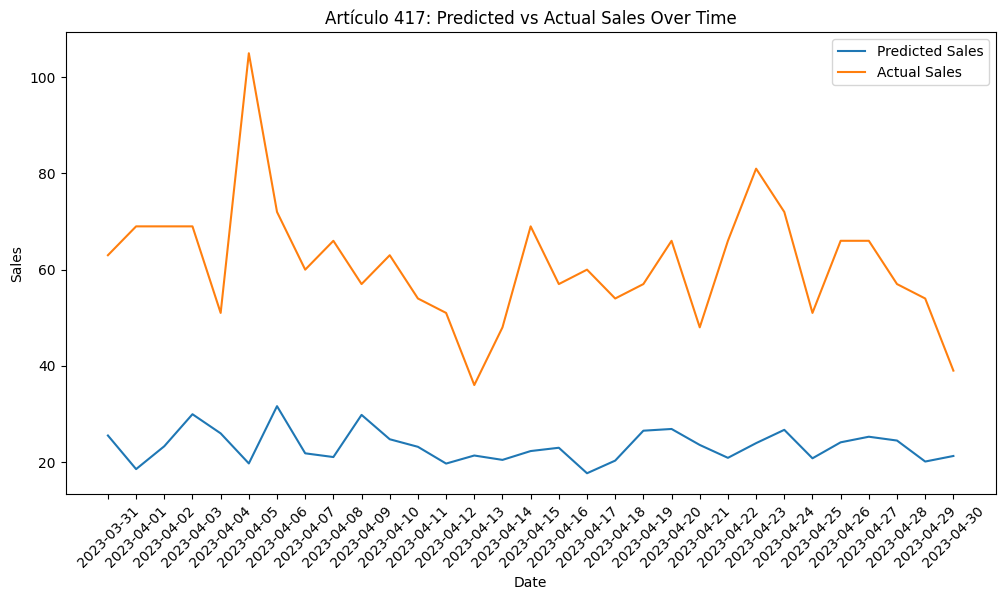


🎨 Graficando artículo 900...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


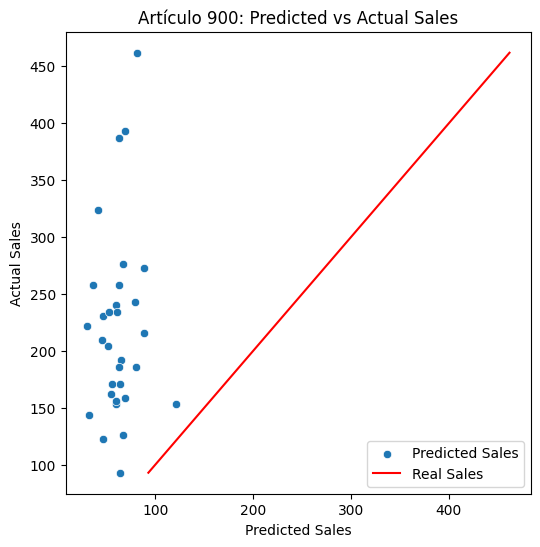

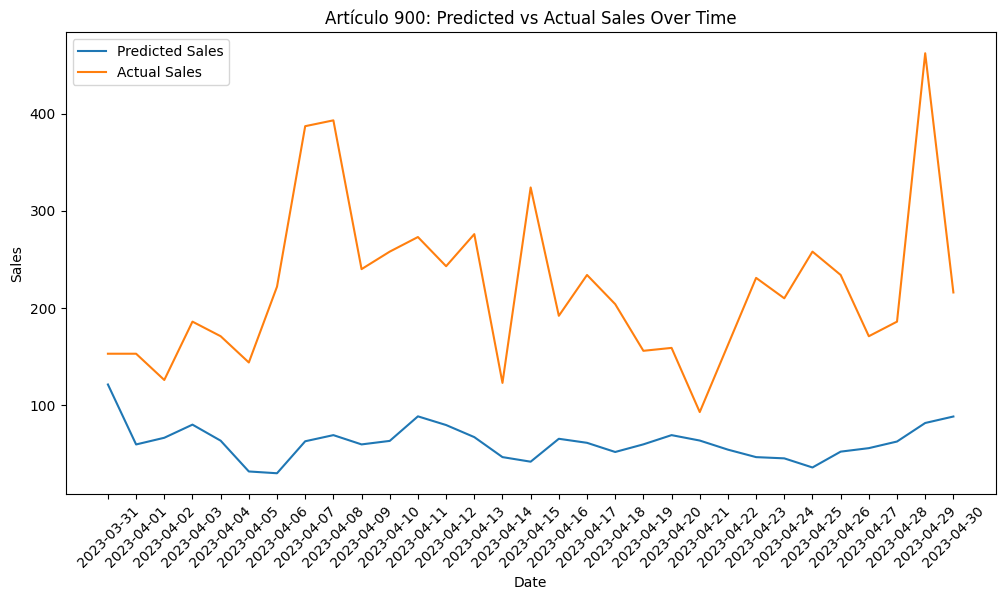


🎨 Graficando artículo 968...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


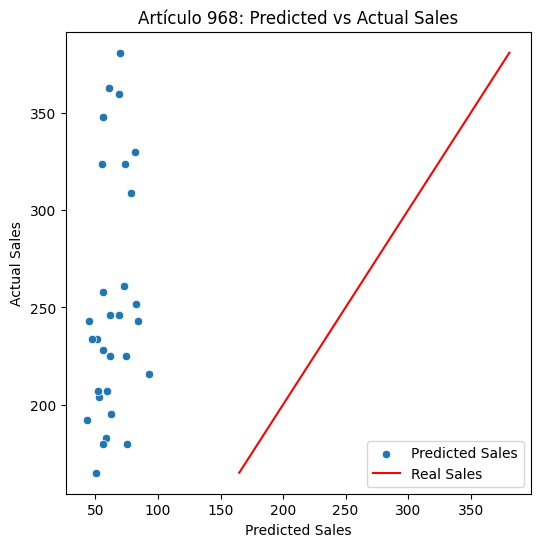

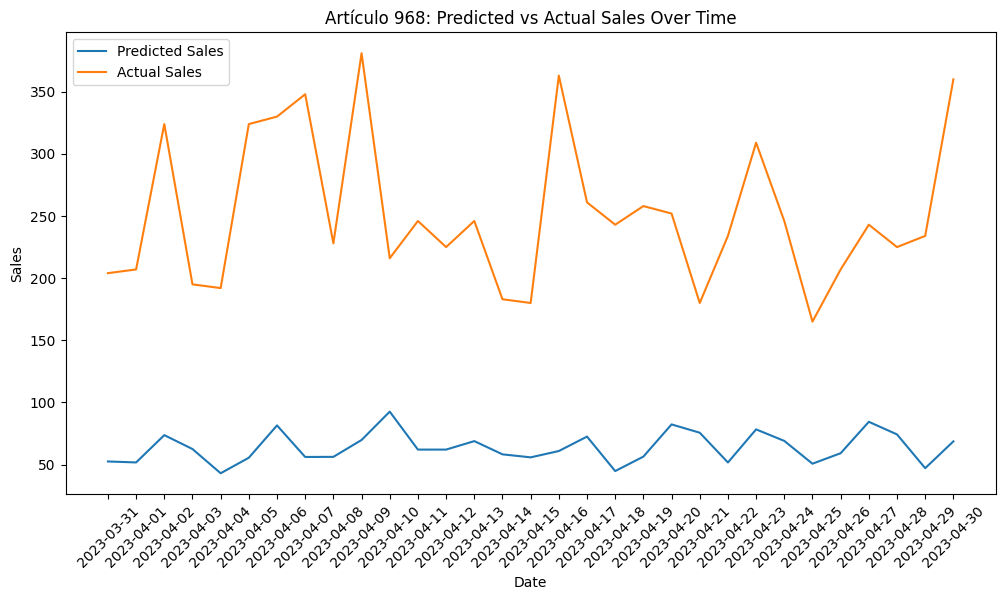


🎨 Graficando artículo 1043...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


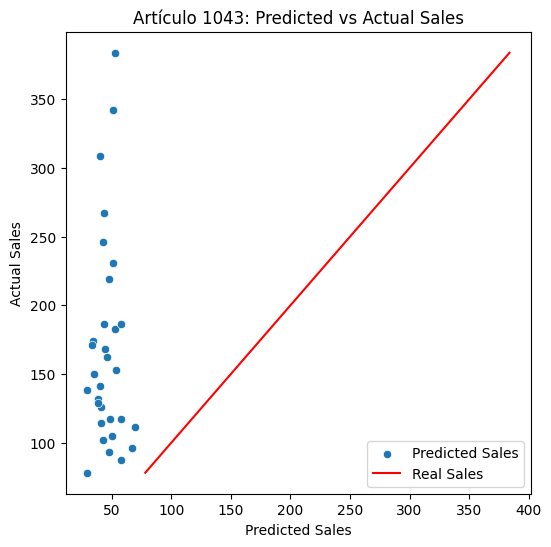

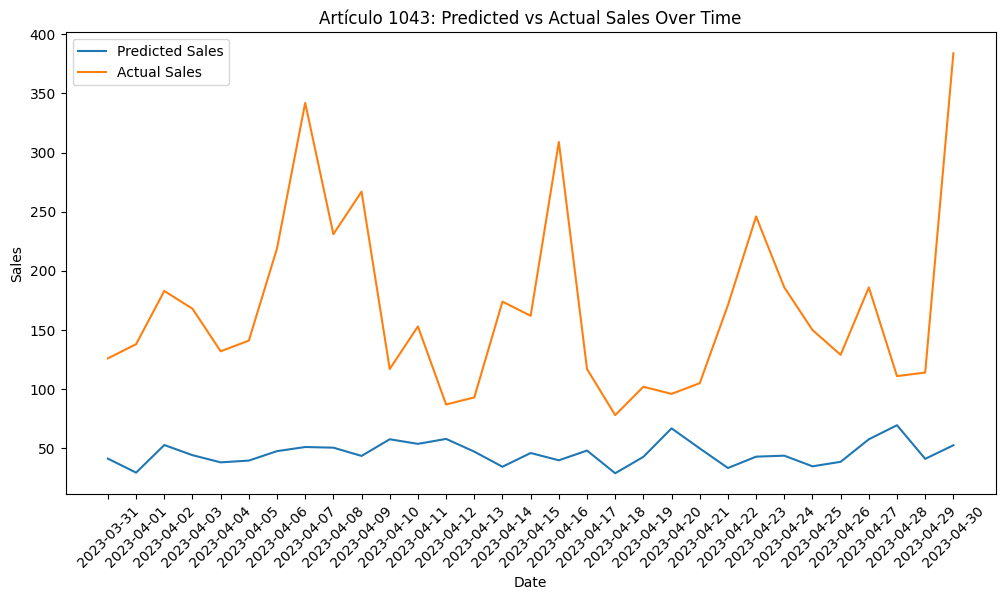


🎨 Graficando artículo 1084...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


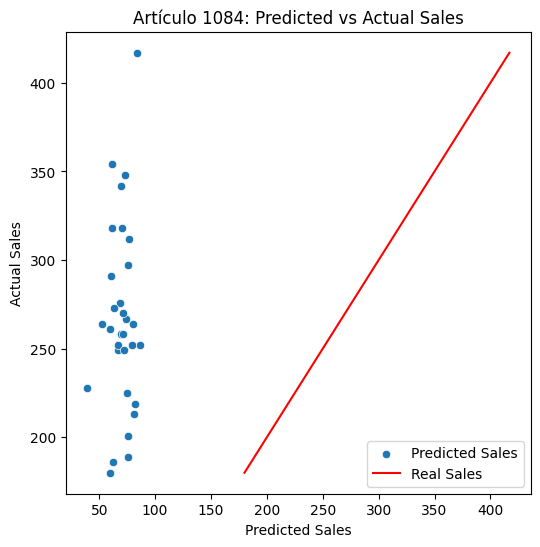

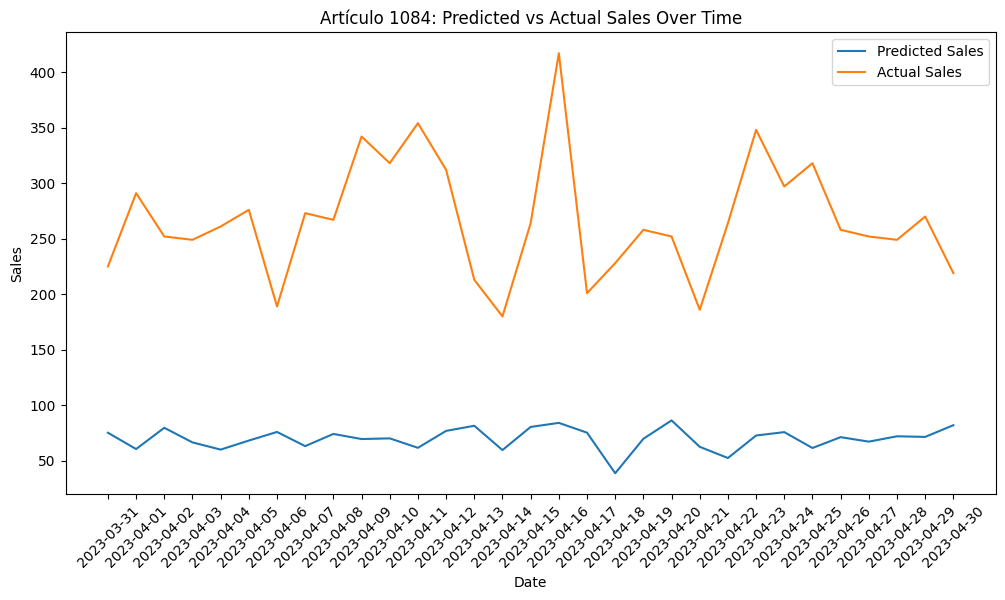


🎨 Graficando artículo 3880...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


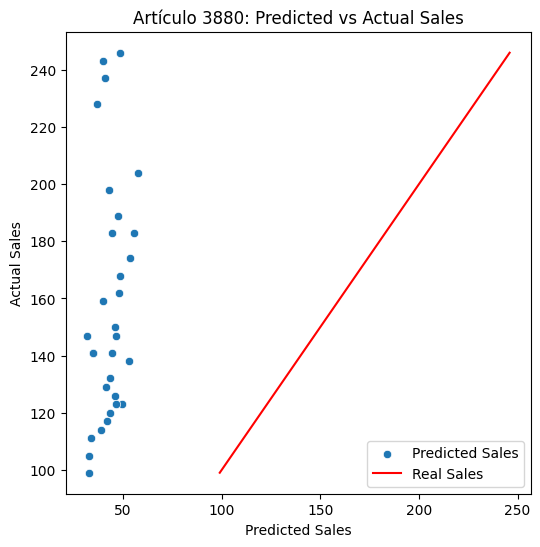

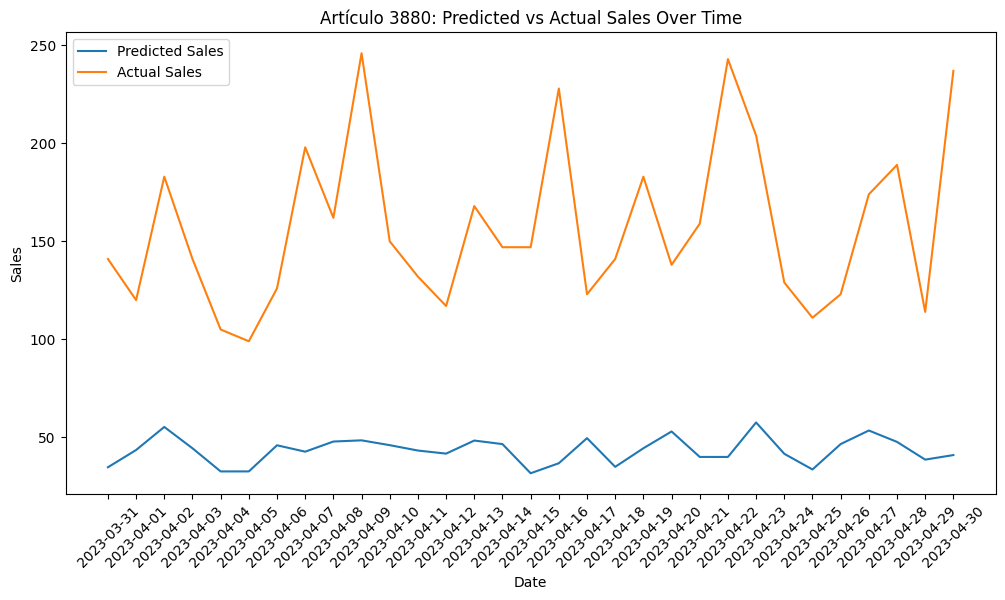


🎨 Graficando artículo 3960...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


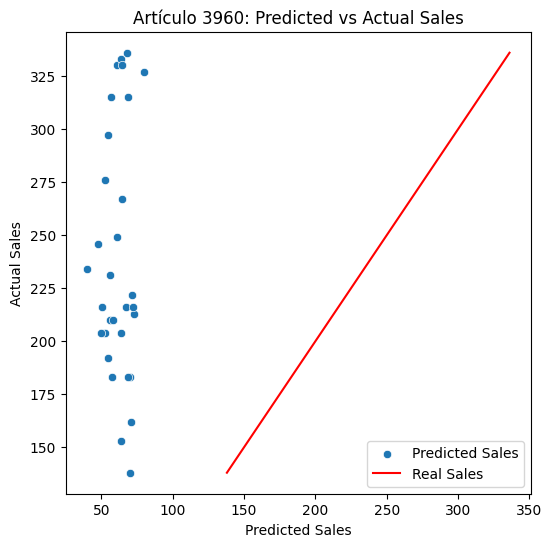

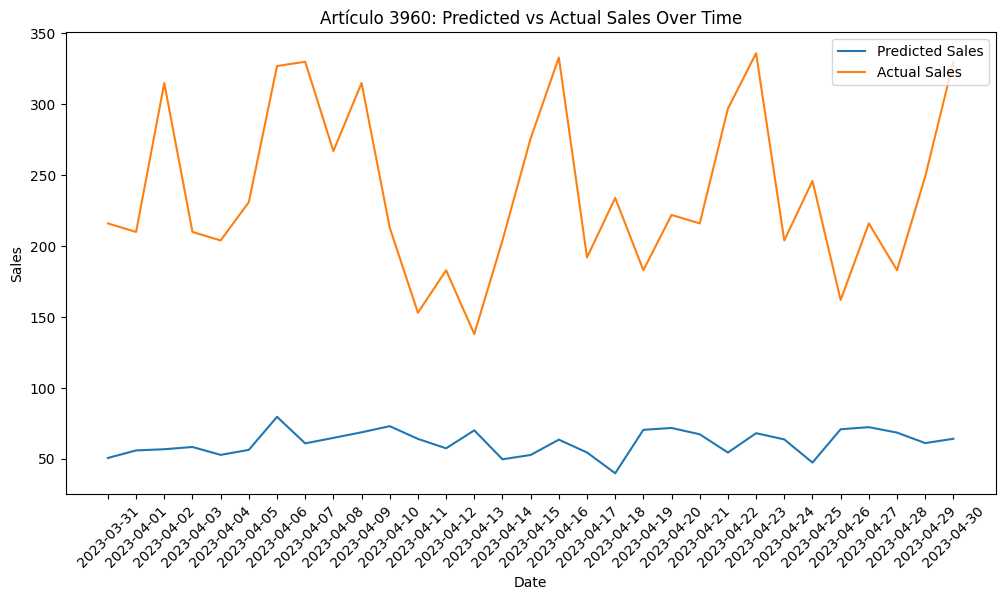


🎨 Graficando artículo 5403...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


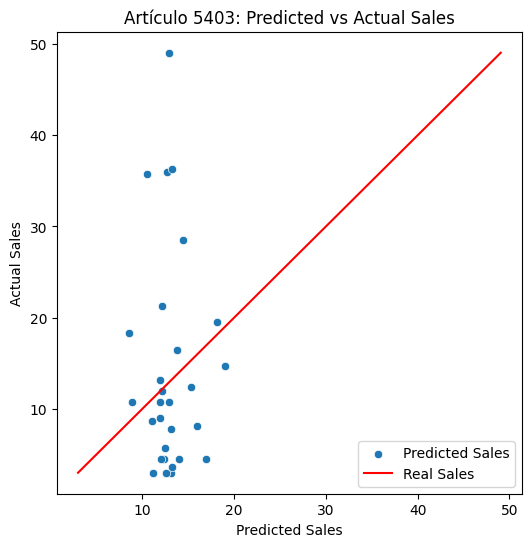

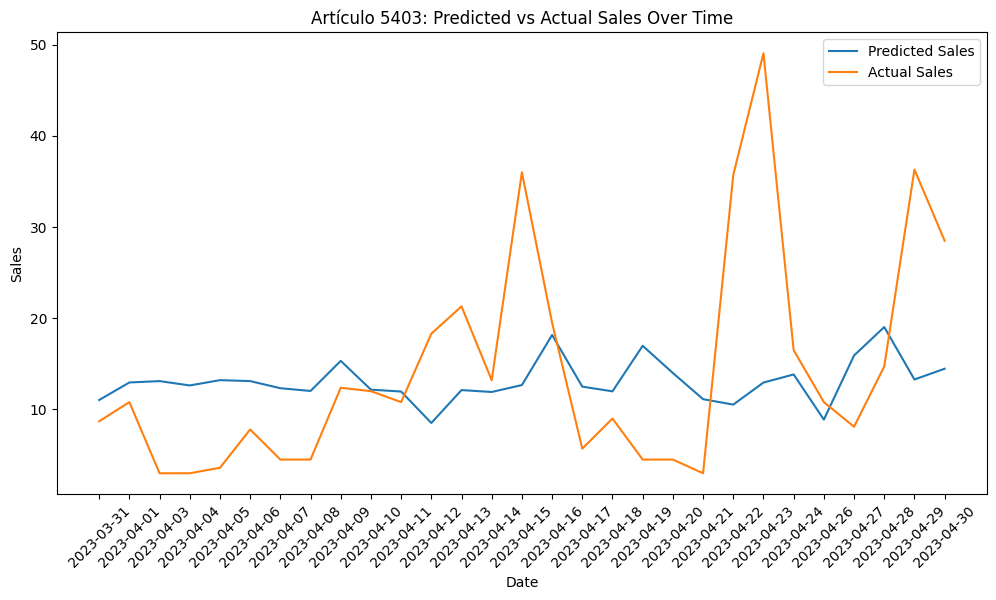


🎨 Graficando artículo 5404...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


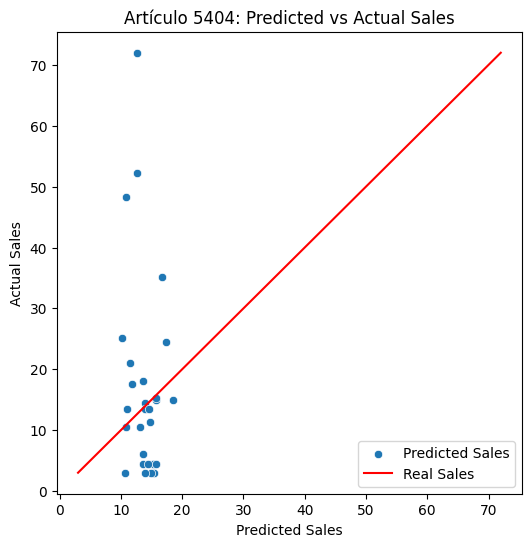

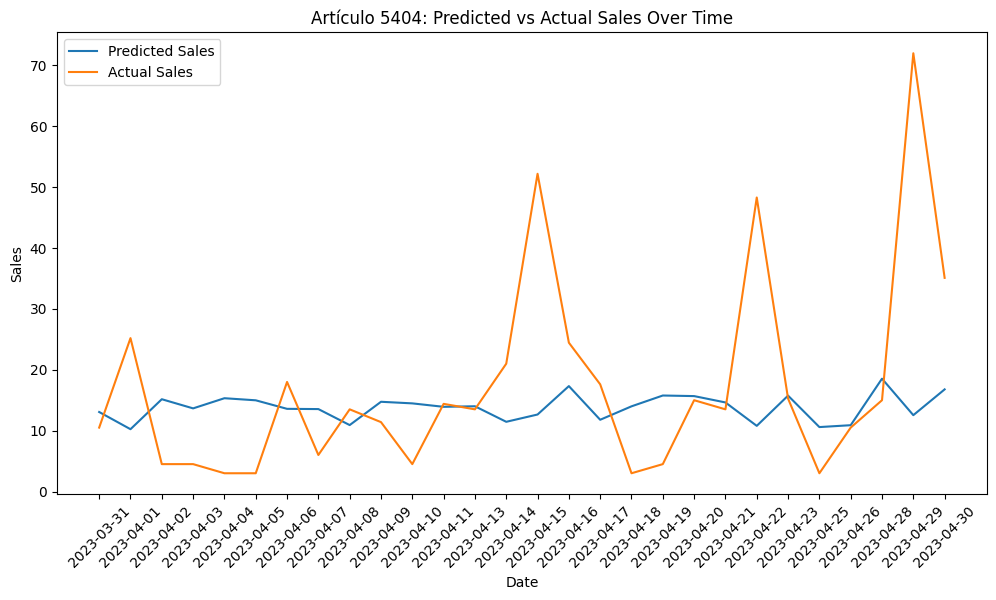


🎨 Graficando artículo 5803...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


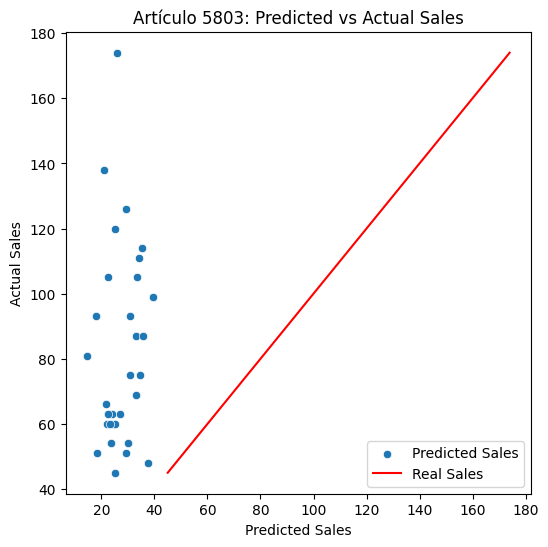

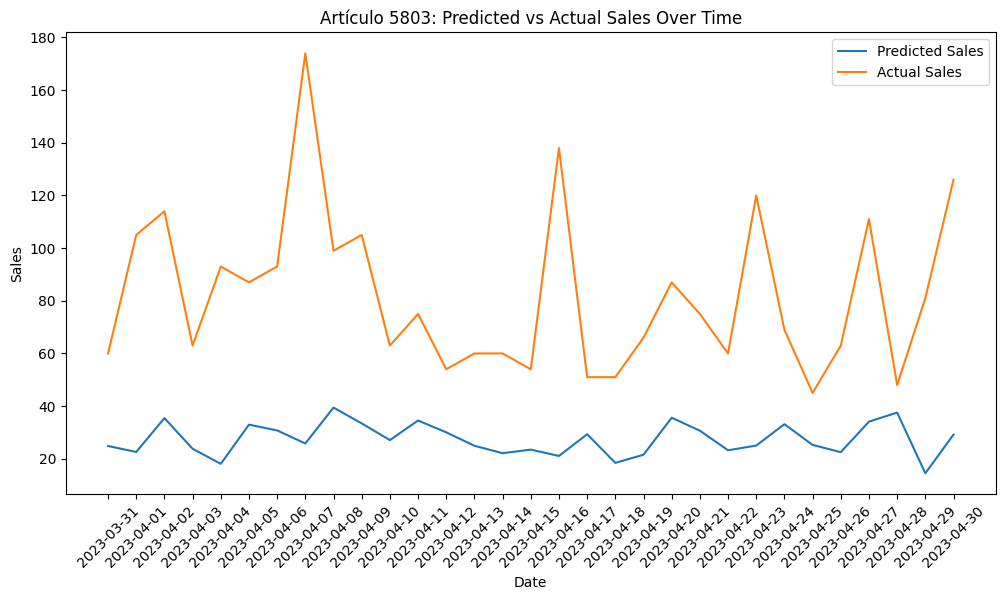


🎨 Graficando artículo 6286...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


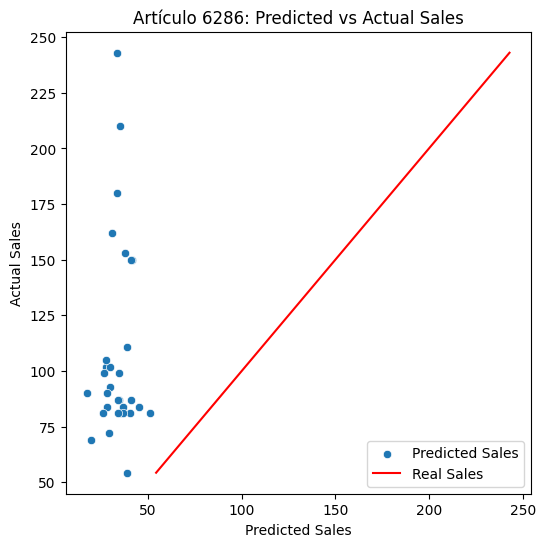

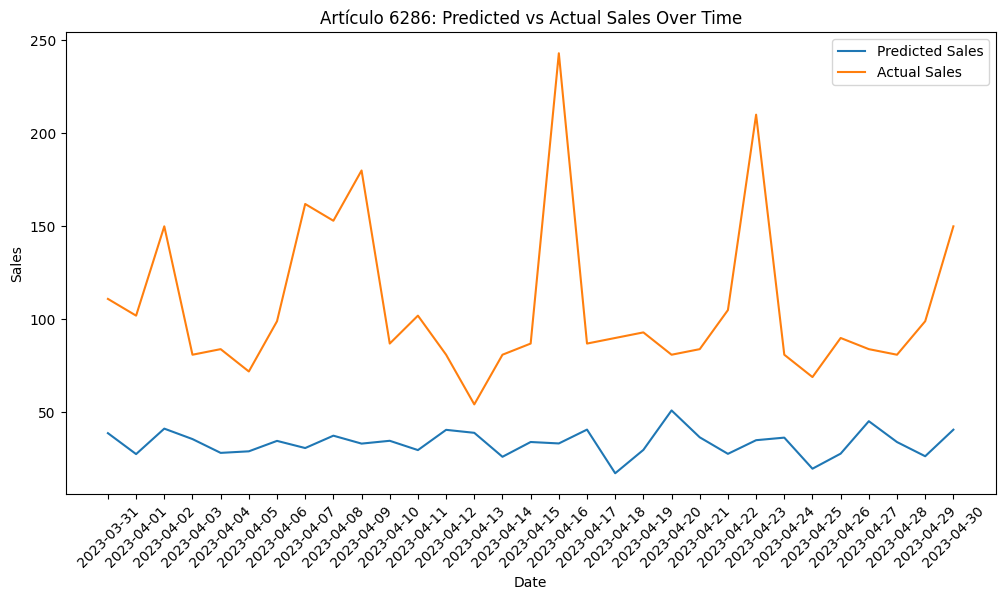


🎨 Graficando artículo 6425...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


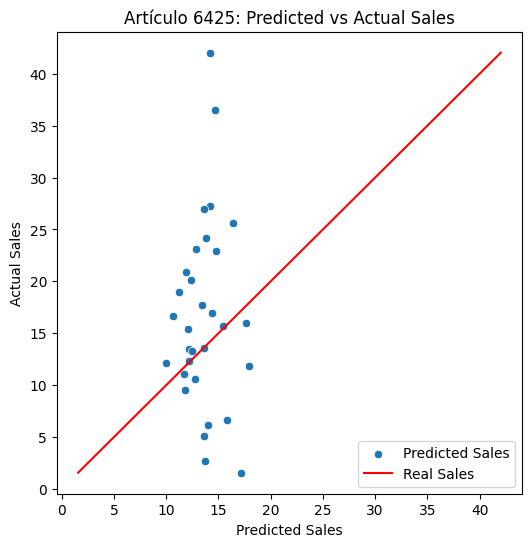

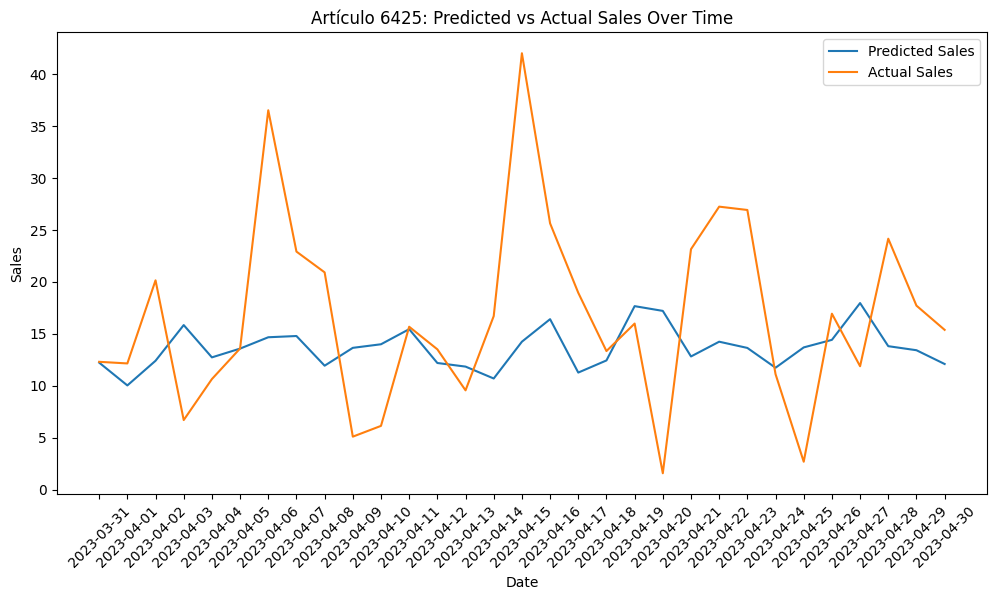


🎨 Graficando artículo 6451...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


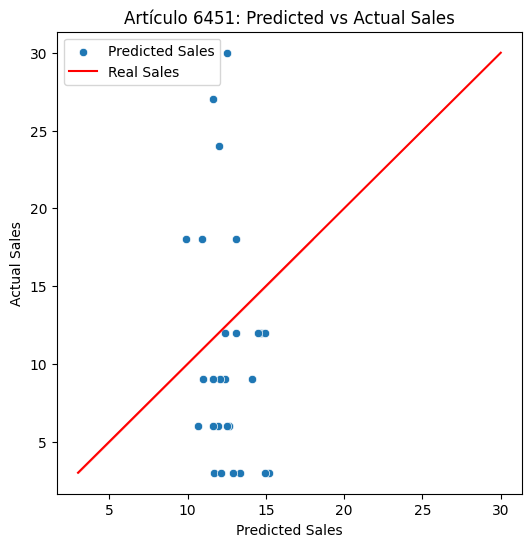

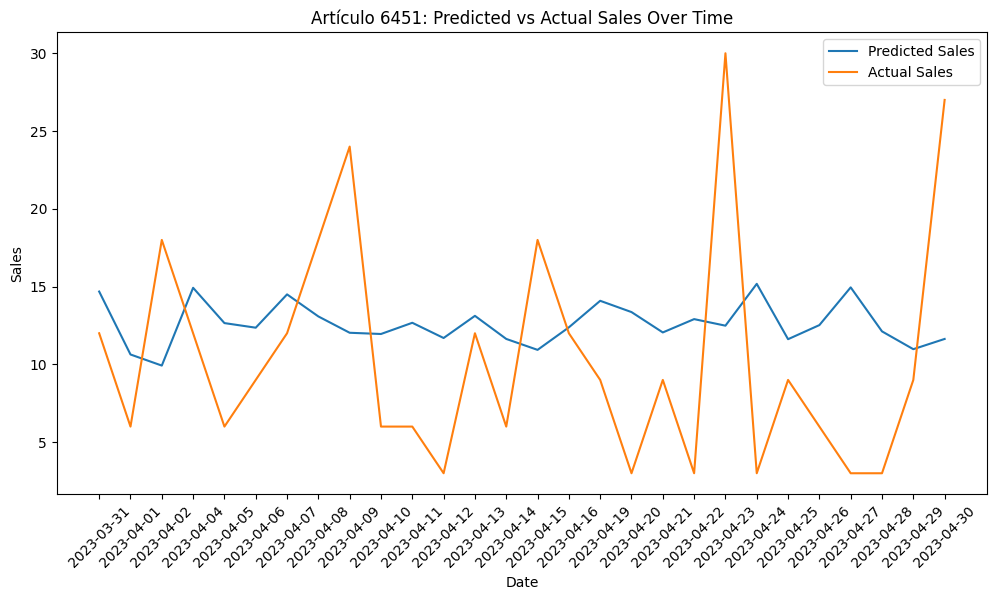


🎨 Graficando artículo 6523...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


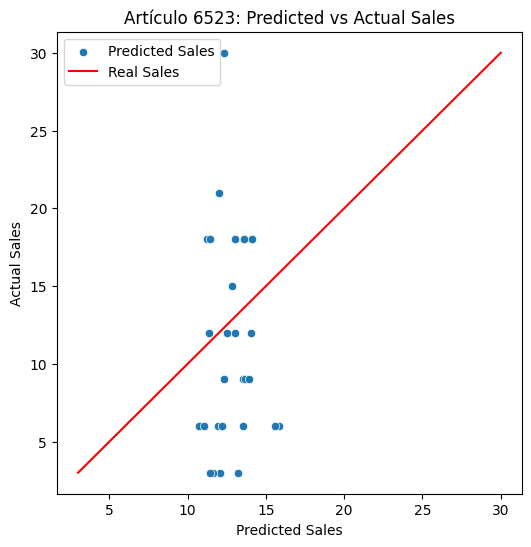

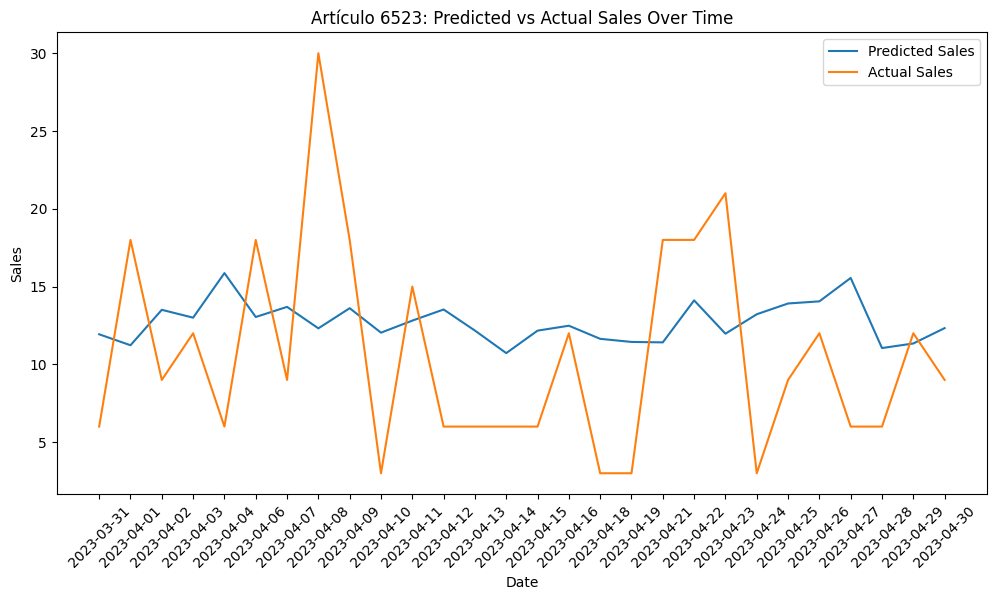


🎨 Graficando artículo 6549...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


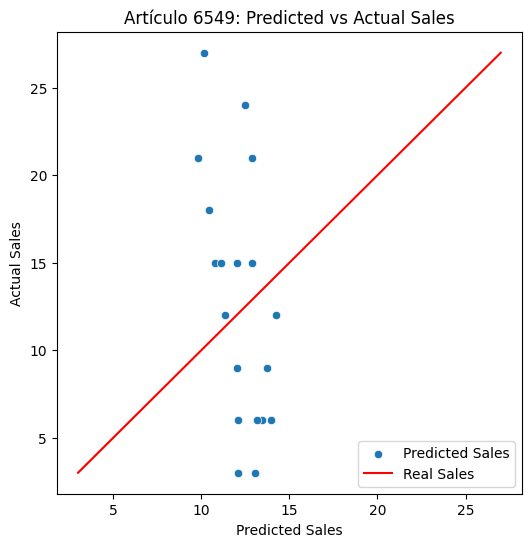

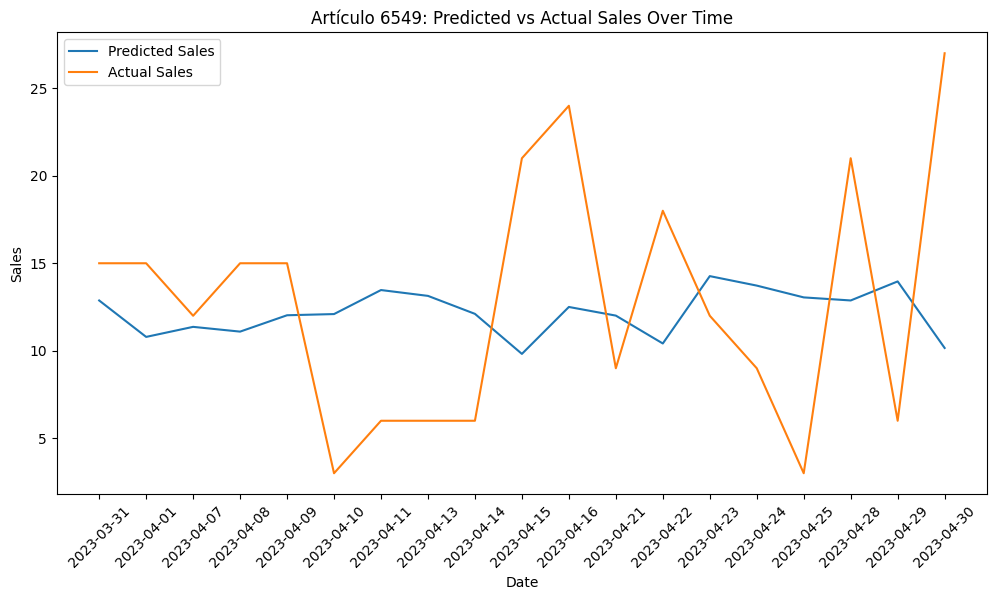

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

for id_articulo, datos_articulo in datos_preparados.items():
    print(f"\n🎨 Graficando artículo {id_articulo}...")

    X_test = datos_articulo["X_test"]
    y_test = datos_articulo["y_test"]

    if len(X_test) == 0:
        print(f"⚠️ Artículo {id_articulo}: No hay datos de prueba para graficar.")
        continue

    # Predicción usando el modelo ya entrenado
    y_pred = final_pipeline.predict(X_test)

    # Obtener fechas para gráfico temporal (debe estar en el dataframe original)
    fechas = dfs_articulos[id_articulo].loc[X_test.index, 'fecha_venta'].astype(str)

    # --- Gráfico 1: Predicted vs Actual (scatter) ---
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f"Artículo {id_articulo}: Predicted vs Actual Sales")
    ax.set_xlabel("Predicted Sales")
    ax.set_ylabel("Actual Sales")

    sns.scatterplot(x=y_pred, y=y_test, ax=ax, label="Predicted Sales")
    sns.lineplot(x=y_test, y=y_test, color="red", ax=ax, label="Real Sales")
    plt.legend()
    plt.show()

    # --- Gráfico 2: Evolución temporal ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Artículo {id_articulo}: Predicted vs Actual Sales Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.set_xticklabels(fechas, rotation=45)

    sns.lineplot(x=fechas, y=y_pred, label="Predicted Sales", ax=ax)
    sns.lineplot(x=fechas, y=y_test, label="Actual Sales", ax=ax)
    plt.legend()
    plt.show()


### Conclusiones del modelo

El modelo `LinearRegression`, no ha sido preciso en las predicciones, tal vez porque el tiempo que se utilizó fue de 30 días, o porque se debe de eliminar algunas columnas que no favorecen para entrenar este modelo.

### 5. Productivización del modelo

👇 Se ha desplegado el modelo y registrado en MLFLOW

```bash
(venv) PS D:\Proyecto> mlflow server
INFO:waitress:Serving on http://127.0.0.1:5000
```

### 6. Subir los resultados a la base de datos

In [95]:
df_predicciones_total = []

for id_articulo, datos_articulo in datos_preparados.items():
    fechas = datos_articulo["df_test"]["fecha_venta"].tolist()
    X_test = datos_articulo["X_test"]
    y_pred = final_pipeline.predict(X_test)  # mismo pipeline
    familia = familias_por_articulo.get(id_articulo, "Desconocida")
    
    df_article_prediction = pd.DataFrame({
        "fecha": fechas,
        "cantidad": y_pred,
        "articulo": [id_articulo] * len(y_pred),
        "familia": [familia] * len(y_pred)
    })
    
    df_predicciones_total.append(df_article_prediction)

# Unir todo en un único DataFrame
df_predicciones = pd.concat(df_predicciones_total, ignore_index=True)

# Vista previa
print(df_predicciones.head(10))


Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advert

Subiendo a la base de datos

In [96]:
DATABASE = "sandbox"
NAME = "JeanPaul"  # ‼️ Cambia esta variable por tu nombre. 

table_name = f"Materials_Prediction_Group_{NAME}"

# Connect to the database
db = DatabaseConnection(DB_USERNAME, DB_PASSWORD, database=DATABASE)
db.insert_dataframe(df_predicciones, table_name)